# How to train and tune a random forest

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from pathlib import Path
import numpy as np

from numpy.random import choice
import pandas as pd
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style('white')
np.random.seed(seed=42)

In [5]:
results_path = Path('results', 'random_forest')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Get Data

In [6]:
with pd.HDFStore('data.h5') as store:
    data = store['us/Alt_Energy/daily']

    data.index.set_names(["Ticker", "date"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5016 entries, ('BE', Timestamp('2019-03-13 00:00:00')) to ('VWSYF', Timestamp('2020-12-30 00:00:00'))
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar_volume  5016 non-null   float64
 1   atr            5016 non-null   float64
 2   bb_down        5016 non-null   float64
 3   bb_high        5016 non-null   float64
 4   bb_low         5016 non-null   float64
 5   bb_mid         5016 non-null   float64
 6   bb_up          5016 non-null   float64
 7   macd           5016 non-null   float64
 8   natr           5016 non-null   float64
 9   rsi            5016 non-null   float64
 10  return_1m      5016 non-null   float64
 11  return_3m      5016 non-null   float64
 12  return_6m      5016 non-null   float64
 13  return_12m     5016 non-null   float64
 14  momentum_3     5016 non-null   float64
 15  momentum_6     5016 non-null   float64
 16  momentum_3_6   501

In [7]:
y = data.target
y_binary = (y > 0).astype(int)
X = pd.get_dummies(data.drop('target', axis=1))

## Random Forests

### Cross-validation parameters

In [8]:
n_splits = 20
train_period_length = 60
test_period_length = 14
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

### Classifier

In [9]:
rf_clf = RandomForestClassifier(n_estimators=100,             # default changed from 10 to 100 in version 0.22 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

#### Cross-Validation with default settings

In [10]:
cv_score = cross_val_score(estimator=rf_clf,
                           X=X,
                           y=y_binary,
                           scoring='roc_auc',
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.0s finished


In [11]:
np.mean(cv_score)

0.5296615313924631

### Regression RF

In [12]:
def rank_correl(y, y_pred):
    return spearmanr(y, y_pred)[0]

ic = make_scorer(rank_correl)

In [13]:
rf_reg = RandomForestRegressor(n_estimators=100, 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False)

In [14]:
cv_score = cross_val_score(estimator=rf_reg,
                           X=X,
                           y=y,
                           scoring=ic,
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.3s finished


In [15]:
np.mean(cv_score)

0.05503359202403937

## Parameter Tuning

### Define Parameter Grid

In [16]:
param_grid = {'n_estimators': [50, 100, 250],
              'max_depth': [5, 15, None],
              'min_samples_leaf': [50, 100, 200]}

### Instantiate GridSearchCV

We will use 10-fold custom cross-validation and populate the parameter grid with values for the key configuration settings:

In [17]:
gridsearch_clf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

### Fit Classifier

In [18]:
gridsearch_clf.fit(X=X, y=y_binary)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 20 folds for each of 27 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x7fb341b1d2e8>,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'min_samples_leaf': [50, 100, 200],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring='roc_auc', verbose=1)

#### Persist Result

In [19]:
joblib.dump(gridsearch_clf, results_path / 'gridsearch_clf.joblib') 

['results/random_forest/gridsearch_clf.joblib']

In [20]:
gridsearch_clf = joblib.load(results_path / 'gridsearch_clf.joblib') 

In [21]:
gridsearch_clf.best_params_

{'max_depth': 5, 'min_samples_leaf': 100, 'n_estimators': 100}

In [22]:
gridsearch_clf.best_score_

0.5411827410680264

#### Feature Importance

A random forest ensemble may contain hundreds of individual trees, but it is still possible to obtain an overall summary measure of feature importance from bagged models.

For a given feature, the importance score is the total reduction in the objective function's value, which results from splits based on this feature, averaged over all trees. Since the objective function takes into account how many features are affected by a split, this measure is implicitly a weighted average so that features used near the top of a tree will get higher scores due to the larger number of observations contained in the much smaller number of available nodes. By averaging over many trees grown in a randomized fashion, the feature importance estimate loses some variance and becomes more accurate.

The computation differs for classification and regression trees based on the different objectives used to learn the decision rules and is measured in terms of the mean square error for regression trees and the Gini index or entropy for classification trees.

`sklearn` further normalizes the feature-importance measure so that it sums up to 1. Feature importance thus computed is also used for feature selection as an alternative to the mutual information measures we saw in Chapter 6, The Machine Learning Process (see SelectFromModel in the sklearn.feature_selection module).
In our example, the importance values for the top-20 features are as shown here:

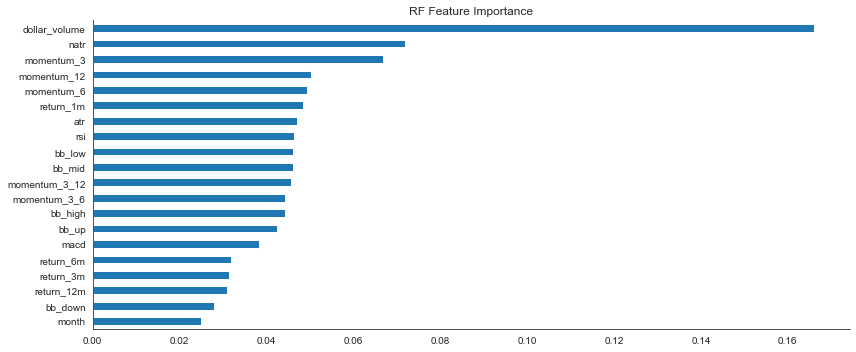

In [23]:
fig, ax = plt.subplots(figsize=(12,5))
(pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
           index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh(ax=ax, title='RF Feature Importance'))
sns.despine()
fig.tight_layout();

### Fit Regressor

In [24]:
gridsearch_reg = GridSearchCV(estimator=rf_reg,
                      param_grid=param_grid,
                      scoring=ic,
                      n_jobs=-1,
                      cv=cv,
                      refit=True,
                      return_train_score=True,
                      verbose=1)

In [25]:
gs_reg = gridsearch_reg

In [26]:
gridsearch_reg.fit(X=X, y=y)

Fitting 20 folds for each of 27 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.5min finished


GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x7fb341b1d2e8>,
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'min_samples_leaf': [50, 100, 200],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring=make_scorer(rank_correl),
             verbose=1)

In [27]:
joblib.dump(gridsearch_reg, results_path / 'rf_reg_gridsearch.joblib') 

['results/random_forest/rf_reg_gridsearch.joblib']

In [28]:
gridsearch_reg = joblib.load(results_path / 'rf_reg_gridsearch.joblib') 

In [29]:
gridsearch_reg.best_params_

{'max_depth': 15, 'min_samples_leaf': 100, 'n_estimators': 250}

In [30]:
f'{gridsearch_reg.best_score_*100:.2f}'

'5.63'

### Compare Results

#### Best Parameters

In [31]:
pd.DataFrame({'Regression': pd.Series(gridsearch_reg.best_params_),
              'Classification': pd.Series(gridsearch_clf.best_params_)})

,Regression,Classification
max_depth,15,5
min_samples_leaf,100,100
n_estimators,250,100


#### Feature Importance

In [32]:
fi_clf = gridsearch_clf.best_estimator_.feature_importances_
fi_reg = gridsearch_reg.best_estimator_.feature_importances_

In [33]:
idx = [c.replace('_', ' ').upper() for c in X.columns]

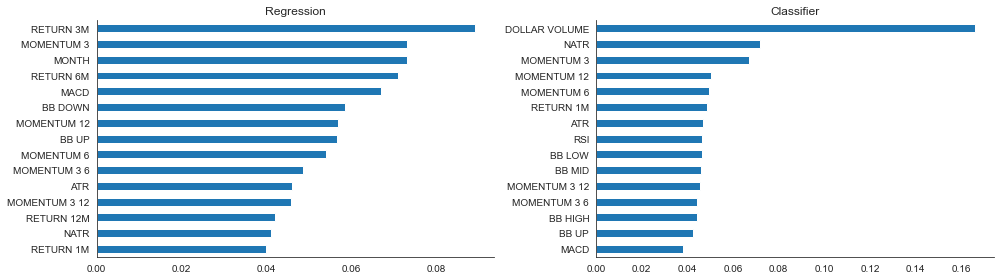

In [34]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
(pd.Series(fi_clf, index=idx)
 .sort_values(ascending=False)
 .iloc[:15]
 .sort_values()
 .plot.barh(ax=axes[1], title='Classifier'))
(pd.Series(fi_reg, index=idx)
 .sort_values(ascending=False)
 .iloc[:15]
 .sort_values()
 .plot.barh(ax=axes[0], title='Regression'))
sns.despine()
fig.tight_layout()